# EE4211 Data Science for IoT, Project Assignment - Question 2

### **Group 6**

**Members:**<br> 
    Ge Xuyan   A0133904L<br>
    Li Jilan   A0224633L<br>
    Yang Di   A0229522H <br>
    Zhang Lu   A0138607B
(In alphabetical order)

## Question 2.1

**Why you may want to forecast the Gas consumption in the future?**

Natural Gas has been widely used in both industries and households. Accurate forecasting of natural Gas consumption can benefit us in several ways:

1. Energy savings. Knowing the demand of natural gas in different areas or districts helps to optimize the process of production, provision and transportation. In the mean time, reduce the energy waste and emission.
2. Energy security. It allows gas companies to detect and prevent the gas leakage during transportation or from the user end. Meanwhile, it can also help to detect the malfunctioning gas meters, which in another way helps to detect the energy leakage and improve the energy security.
3. Urban planning. Accurate and reasonable forecasting of natural gas consumption is important for the government to make urban planning and infrastructure development.

**Who would find this information valuable?**

As mentioned above, some Government departments, End users, Gas companies, Gas distribution companies, Gas production countries and even our environment will benefit from it.<br>For example, a country relying on importing Gas source from other countries, with the prediction model, the Government department can estimate the upcoming annual Gas consumption, so that they can make reasonable decision on the amount of import and evaluate the corresponding financial budget.<br>
As for Gas user or Gas company, the prediction model can provide a reference on malfunction gas meter detection by comparing the actual reading value with predicted value, Etc.

**What can you do if you have a good forecasting model?**

With good forecasting model, we could:

1. Work with the Gas industry to improve efficiency.
2. Propose more reasonable Gas pricing strategies based on demand relationships.
3. Better improve transportation safety in preventing leakage
4. Analyze user habits more accurately to better serve users 

**Data preprocessing**
<br>Before build up a prediction model, we have to prune the defective data like spiking or dreasing with data_Prune func from Question 1. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataport-export_Gas_oct2015-mar2016.csv') # to read data

In [3]:
def data_Prune(df):    # smooth the spiking data and correct the dreasing data
    user_df = df.groupby(['dataid'])
    for user_id,data in user_df :
        reading = data.meter_value.values
        diff = np.diff(reading)
        when_decrease = np.where(diff < 0)[0] + 1
        if when_decrease.size>0:
            for i in range(1,len(reading)):
                if reading[i] > reading[-1]:
                    reading[i] = reading[i - 1]
                elif reading[i] < reading[i - 1]:
                    reading[i] = reading[i - 1]
            df.loc[df['dataid'] == user_id, 'meter_value'] = reading
    return df

In [4]:
df = data_Prune(df)

In [5]:
# Tranfer the time information into Python timestamp format. 
def local2utc(time):
    return pd.Timestamp(time)
df.localminute = df.apply(lambda r: local2utc(r.localminute), axis=1)

In [6]:
from datetime import timedelta, date 
import datetime 
import seaborn as sns 
import warnings

The question requires us to predict the hourly reading value for the next hour, so right here, we are using hourly average reading value to approach the actual hourly reading.<br>
** It means that for each hour, we calculate the **Average Gas Consumption** to repersent the hourly reading!

In [7]:
# to get avarage hourly reading values 
user_df = df.groupby(['dataid'], sort=['localminute'])
processed_set = {}

for user_idx in user_df.groups.keys():
        new_set = []
        current_set = user_df.get_group(user_idx).values   # used for caculate avarage hourly reading
        temporary = []

        for row in current_set:
            row[0] = row[0].replace(minute = 0, second = 0) # to remove the info on minute and second .
            temporary .append(row)
        current_set = temporary 

        # avarage hourly reading set
        avr_set = []
        current_time = None
        current_number = 0    # the actually reading
        current_count = 0     # the reading number in one hour

        for i in current_set:
            if current_time is None:
                current_time = i[0]     # the chosen one hour period
                current_number = i[2]   # the reading value
                current_count = 1
            elif current_time == i[0]:
                current_number = current_number+i[2] # to accumulate all the reading values in this one hour period
                current_count  = current_count+1
            else:
                avr_set.append([current_time, user_idx, (current_number / current_count)])
                current_time = i[0]
                current_number = i[2]
                current_count = 1
                
        # to get means of accumulate all the reading values in this one hour period
        avr_set.append([current_time, user_idx, (current_number / current_count)])  

        processed_set[user_idx] = avr_set

**Why do we chose average reading value for a certain hour period?** <br>To some extent, what we desire is a trend of gas consumption without extreme accuate reading. In addition, as we mentioned in our proposal, we want to make use of prediction to estimate upcoming gas consumption to ensure a proper plan for gas distribution and transportation.<br> We only need to get an estimated value with the same order of magnitudes for the actual value.<br>Therefore, using the average value to represent the hourly reading for a certain hour is reasonable.

In [8]:
hourly_OGdata = processed_set

Extract all the meters' readings from dataset.

## Question 2.2
**Linear regression**<br>
At this part, we will use processed data to build up a linear regression model. Our strategy is to build up a model for each gas meter.

In [9]:
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# create linear regression object
linear = linear_model.LinearRegression()

In [10]:
def linear_pred(user_id,hourly_OGdata=hourly_OGdata): # to chose the Gas id for fitting its hourly reading 
        user_id = user_id # to choose Gas meter ID
        reading = np.array(hourly_OGdata[user_id]) # convert to np.array
        y = reading[:,2]    # extract the reading vaule
        x = np.arange(len(y)).reshape(-1, 1) # using sample point to represent the specific time
        
        train_x=[]
        train_y=[]
        test_x=[]
        test_y=[]
        
        for i in range(len(x)):
            if i % 5 != 0:
                train_x.append(x[i])
                train_y.append(y[i])
            else:
                test_x.append(x[i])
                test_y.append(y[i])

        # train the model using the training sets
        linear.fit(train_x, train_y)
        # make predictions using the testing set
        reading_pred = linear.predict(test_x)

        # plot the curve of prediction versus actual data
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.plot(test_x, reading_pred, '.b--', label='Prediction')
        ax.plot(test_x, test_y, '.r--', label='Hourly readings')
        ax.set_facecolor('beige')
        plt.xlabel('Hours (Start from '+str(reading[0][0])+')')
        plt.ylabel('Reading Value (ft^3)')
        label='Time series plot of the actual and predicted hourly meter readings for user id : '+str(user_id)
        plt.title(label)
        plt.grid(True)
        leg = ax.legend()
        
        # plot the curve of prediction along with the perfect fitting line    
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.scatter(test_y, reading_pred, c='b',s=2, label='Prediction vs Actual')
        ax.plot(test_y, test_y, '-r', label='perfect fit')
        plt.xlabel('Actual Value (ft^3)')
        plt.ylabel('Reading Value (ft^3)')
        label='Scatter plot of actual vs predicted meter readings for user id : '+str(user_id)
        plt.title(label)
        plt.grid(b=True, which='both', axis='both')
        leg = ax.legend()
        print('\n')
        
        print('Evaluation for Gas meter: ',user_id)
        
        # the coefficients
        print('Coefficients: ', linear.coef_)
        
        # the mean squared error
        print('Mean squared error:', mean_squared_error(test_y,reading_pred))
        
        # the coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination', r2_score(test_y,reading_pred))
        return

To represent the fitting model's performance, we chose 4 gas meters as examples,



Evaluation for Gas meter:  35
Coefficients:  [1.36927585]
Mean squared error: 564519.3213677013
Coefficient of determination 0.9481398840598005


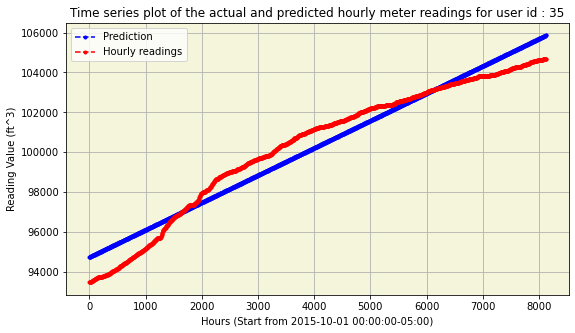

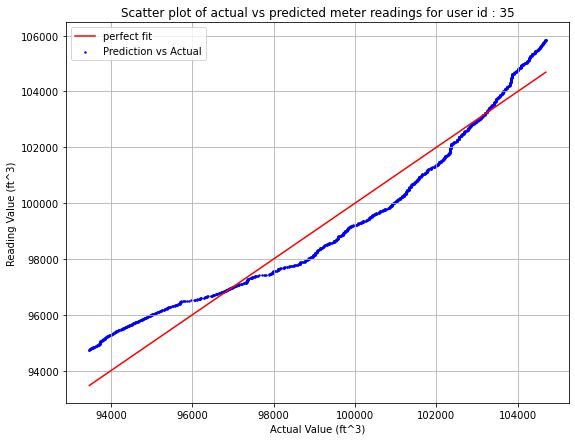

----------------------------------------------------------------




Evaluation for Gas meter:  44
Coefficients:  [6.75761786]
Mean squared error: 318299.4276958779
Coefficient of determination 0.9103743419860965


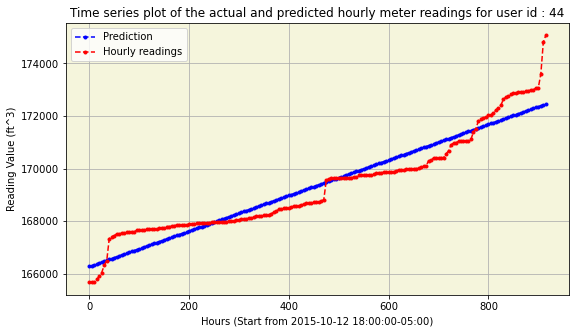

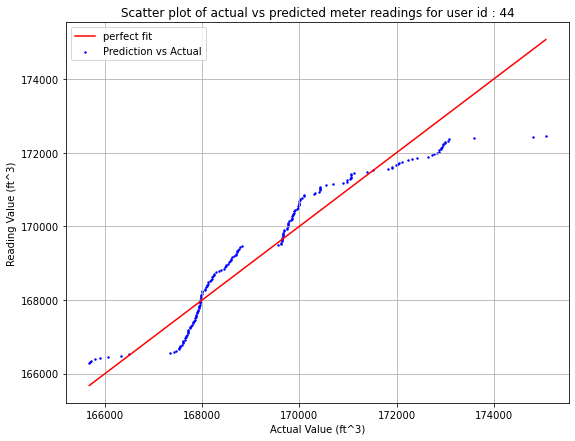

----------------------------------------------------------------




Evaluation for Gas meter:  739
Coefficients:  [0.67836736]
Mean squared error: 2654759.6438578637
Coefficient of determination 0.8242210736465194


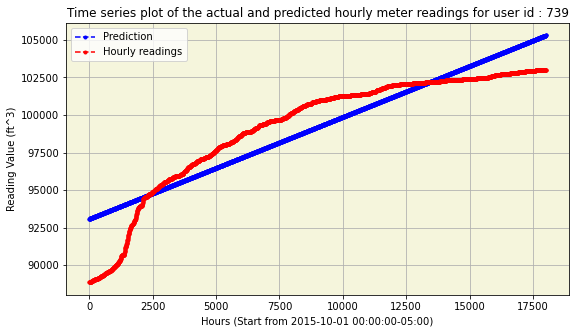

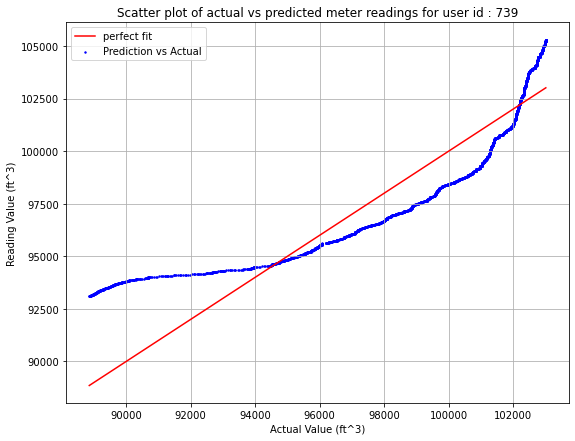

----------------------------------------------------------------




Evaluation for Gas meter:  8890
Coefficients:  [3.37297836]
Mean squared error: 7456975.513725835
Coefficient of determination 0.9190112078780516


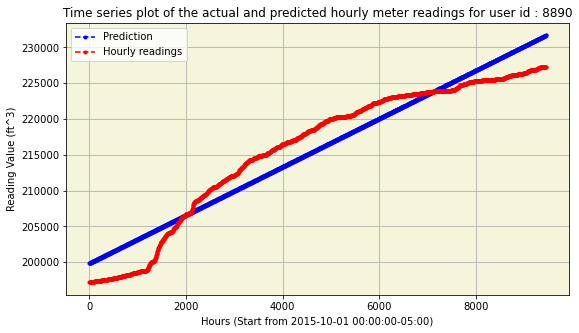

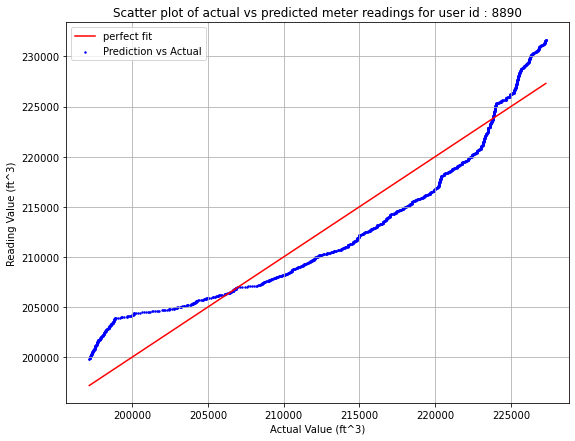

----------------------------------------------------------------




In [11]:
chosen_id=[35,44,739,8890] # chose several Gas meter for linear fitting
for i in chosen_id:
    linear_pred(user_id=i,hourly_OGdata=hourly_OGdata)
    plt.show()
    print('----------------------------------------------------------------\n\n')

As shown above， We used $MSE$ and $R^2$ score to estimate the accuracy of our prediction.<br> 

Gas meter|Average hourly gas usage|$MSE$|R^2 score
 :--------:  | :--------: | :--------: | :--------: 
 35 | 1.37$𝑚^3$ | 564519.321 | 0.9481 
 44	|6.76  $𝑚^3$ |	318299.428|	0.9103 
 739 |	0.68  $𝑚^3$| 	2654759.643|	0.8242 
 8890 |	3.37 $ 𝑚^3$| 	456975.513	|0.9190

According to the curve of prediction versus actual reading value, it is clearly obeserved that the prediction curves indeed approximate the actual reading variation's trend. However, Mean squared error ($MSE$) and Coefficient of determination ($R^2$) score based on linear regression model indicate that the model performs mediocrely. In the next part we will introduce support vector regression.

## Question 2.3
**Support Vector Regression**

In [12]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# create SVR object
svr = make_pipeline(StandardScaler(), SVR(C=1000.0, epsilon=0.2))

In [13]:
def svr_pred(user_id,hourly_OGdata=hourly_OGdata): # to chose the Gas id for fitting its hourly reading 
        user_id = user_id # to choose Gas meter ID
        reading = np.array(hourly_OGdata[user_id]) # convert to np.array
        y = reading[:,2]    # extract the reading vaule
        x = np.arange(len(y)).reshape(-1, 1) # using sample point to represent the specific time
        
        train_x=[]
        train_y=[]
        test_x=[]
        test_y=[]
        
        for i in range(len(x)):
            if i % 5 != 0:
                train_x.append(x[i])
                train_y.append(y[i])
            else:
                test_x.append(x[i])
                test_y.append(y[i])
                    
        # train the model using the training sets
        svr.fit(train_x, train_y)
        # make predictions using the testing set
        reading_pred = svr.predict(test_x)
        
        # plot the curve of prediction versus actual data
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.plot(test_x, reading_pred, '.b--', label='Prediction')
        ax.plot(test_x, test_y, '.r--', label='Hourly readings')
        ax.set_facecolor('beige')
        plt.xlabel('Hours (Start from '+str(reading[0][0])+')')
        plt.ylabel('Reading Value (ft^3)')
        label='Time series plot of the actual and predicted hourly meter readings for user id : '+str(user_id)
        plt.title(label)
        plt.grid(True)
        leg = ax.legend()
        
         # plot the curve of prediction along with the perfect fitting line         
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.scatter(test_y, reading_pred,c= 'b',s=2, label='Prediction vs Actual')
        ax.plot(test_y, test_y, 'r', label='perfect fit')
        plt.xlabel('Actual Value (ft^3)')
        plt.ylabel('Reading Value (ft^3)')
        label='Scatter plot of actual vs predicted meter readings for user id : '+str(user_id)
        plt.grid(True)
        plt.title(label)
        leg = ax.legend();
        
        print('Evaluation for Gas meter: ',user_id)
        # the coefficients
       # print('Coefficients: ', svr.coef_)
        # the mean squared error
        print('Mean squared error:', mean_squared_error(test_y,reading_pred))
        # the coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination', r2_score(test_y,reading_pred))
        return

Evaluation for Gas meter:  35
Mean squared error: 4530.9312218907335
Coefficient of determination 0.9995837616010821


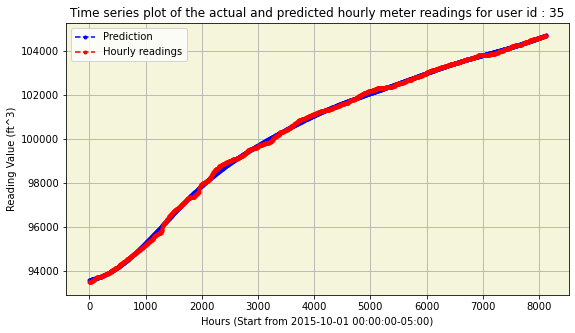

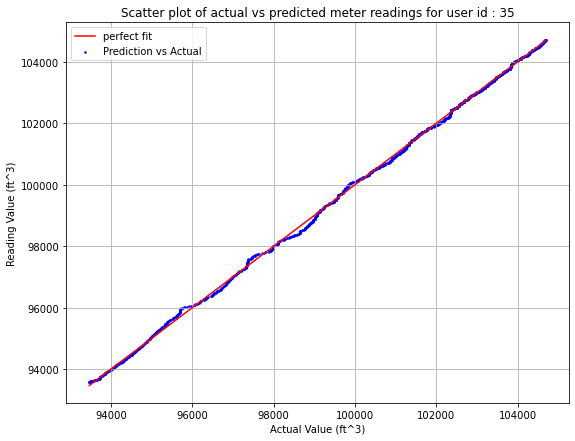

----------------------------------------------------------------


Evaluation for Gas meter:  44
Mean squared error: 113455.58018770308
Coefficient of determination 0.9680535679775469


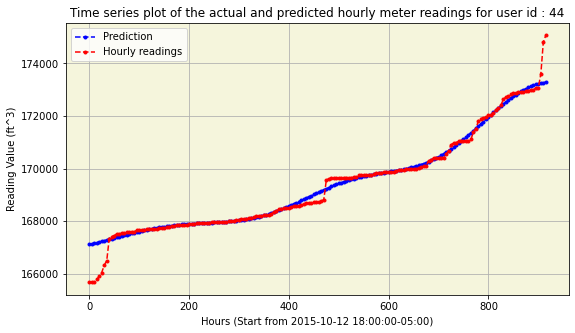

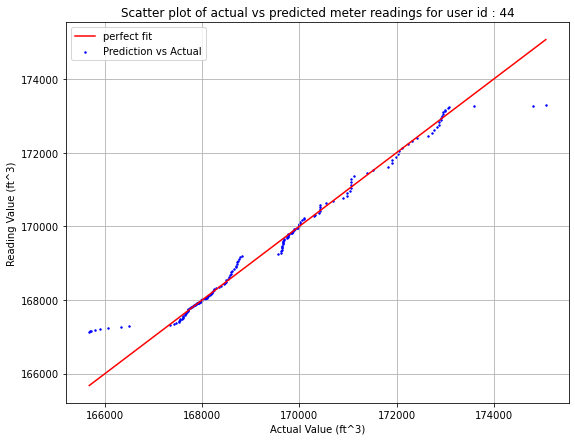

----------------------------------------------------------------


Evaluation for Gas meter:  739
Mean squared error: 58902.02440468805
Coefficient of determination 0.9960999352111377


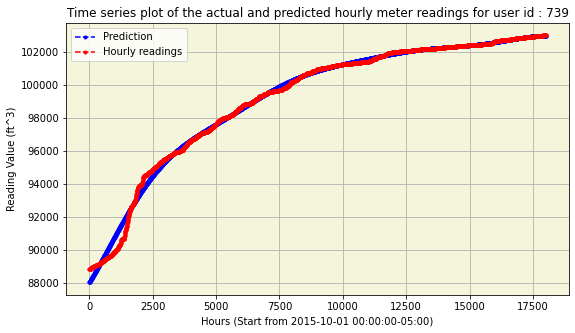

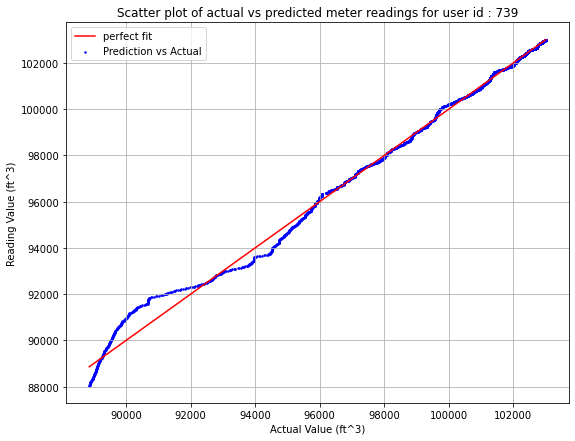

----------------------------------------------------------------


Evaluation for Gas meter:  8890
Mean squared error: 119306.02767791528
Coefficient of determination 0.9987042399352504


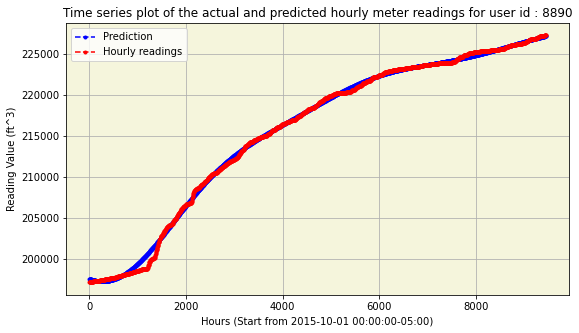

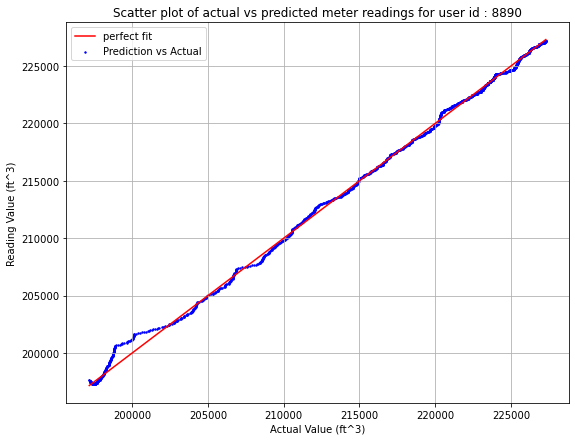

----------------------------------------------------------------




In [14]:
chosen_id=[35,44,739,8890] # chose several Gas meter for linear fitting
for i in chosen_id:
    svr_pred(user_id=i,hourly_OGdata=hourly_OGdata)
    plt.show()
    print('----------------------------------------------------------------\n\n')

Gas meter|$MSE$|R^2 score
 :--------:  | :--------: | :--------:
 35	|4530.931	|0.999
 44	|113455.580	|0.9680 
 739 |58902.024|0.9960 
 8890 |119306.027|0.9987 

To compare the fitting performance between **Linear regression model** and **Support vector regression model**, we use $MSE$ and $R^2$ as the measuring criteria.<br> Intuitively and statistically speaking, SVR model **outperforms** linear regression model on both $MSE$ and $R^2$.<br> 

**Additional - Polynomial Regression**

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=4
poly=make_pipeline(PolynomialFeatures(degree),LinearRegression())

In [16]:
def poly_pred(user_id,hourly_OGdata=hourly_OGdata): # to chose the Gas id for fitting its hourly reading 
        user_id = user_id # to choose Gas meter ID
        reading = np.array(hourly_OGdata[user_id]) # convert to np.array
        y = reading[:,2]    # extract the reading vaule
        x = np.arange(len(y)).reshape(-1, 1) # using sample point to represent the specific time
        
        train_x=[]
        train_y=[]
        test_x=[]
        test_y=[]
        
        for i in range(len(x)):
            if i % 5 != 0:
                train_x.append(x[i])
                train_y.append(y[i])
            else:
                test_x.append(x[i])
                test_y.append(y[i])
                    
        # train the model using the training sets
        poly.fit(train_x, train_y)
        # make predictions using the testing set
        reading_pred = poly.predict(test_x)
        
        # plot the curve of prediction versus actual data
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.plot(test_x, reading_pred, '.b--', label='Prediction')
        ax.plot(test_x, test_y, '.r--', label='Hourly readings')
        ax.set_facecolor('beige')
        plt.xlabel('Hours (Start from '+str(reading[0][0])+')')
        plt.ylabel('Reading Value (ft^3)')
        label='Time series plot of the actual and predicted hourly meter readings for user id : '+str(user_id)
        plt.title(label)
        plt.grid(True)
        leg = ax.legend()
        
        # plot the curve of prediction along with the perfect fitting line  
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.scatter(test_y, reading_pred,c= 'b',s=2, label='Prediction vs Actual')
        ax.plot(test_y, test_y, 'r', label='perfect fit')
        plt.xlabel('Actual Value (ft^3)')
        plt.ylabel('Reading Value (ft^3)')
        label='Scatter plot of actual vs predicted meter readings for user id : '+str(user_id)
        plt.title(label)
        plt.grid(True)
        leg = ax.legend();
        
        print('Evaluation for Gas meter: ',user_id)
        # the coefficients
        #print('Coefficients: ', svr.coef_)
        # the mean squared error
        print('Mean squared error:', mean_squared_error(test_y,reading_pred))
        # the coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination', r2_score(test_y,reading_pred))
        return

Evaluation for Gas meter:  35
Mean squared error: 20137.477536391318
Coefficient of determination 0.9981500510606967


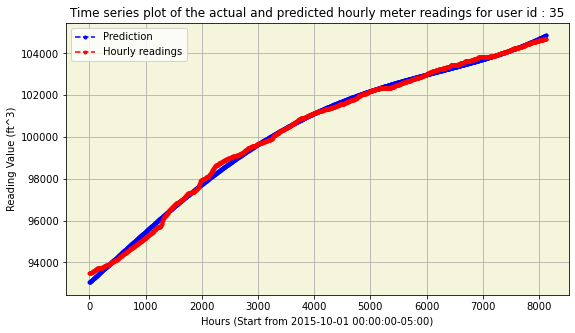

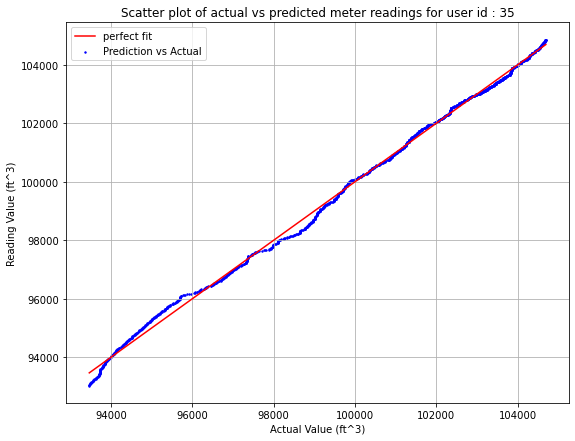

----------------------------------------------------------------


Evaluation for Gas meter:  44
Mean squared error: 98416.87424071085
Coefficient of determination 0.972288115070307


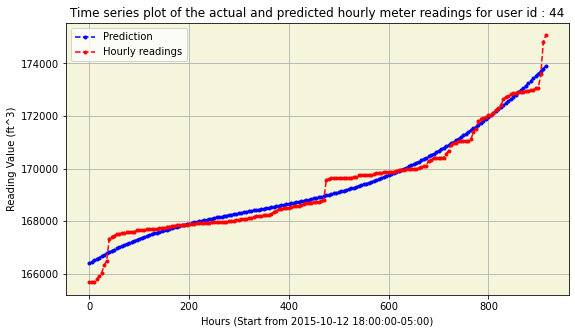

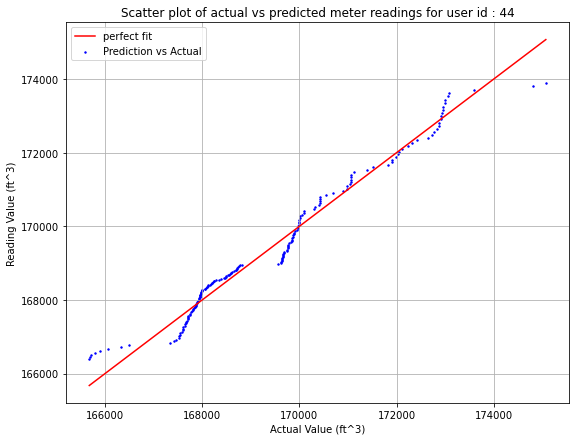

----------------------------------------------------------------


Evaluation for Gas meter:  739
Mean squared error: 90652.27664031425
Coefficient of determination 0.9939976638200749


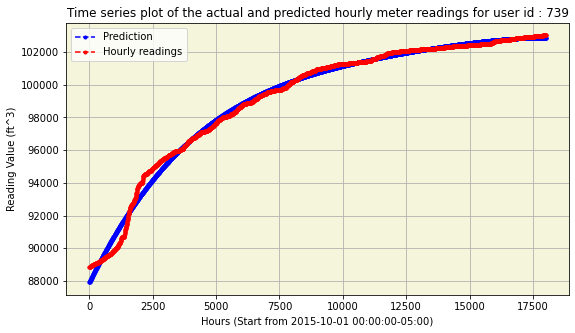

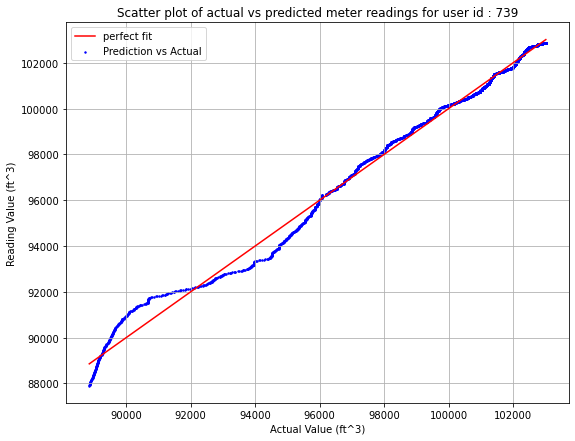

----------------------------------------------------------------


Evaluation for Gas meter:  8890
Mean squared error: 458835.22222271515
Coefficient of determination 0.9950166779597944


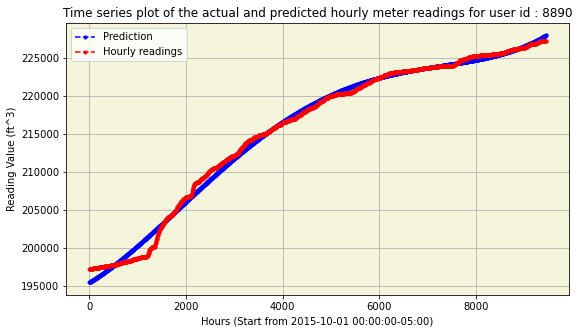

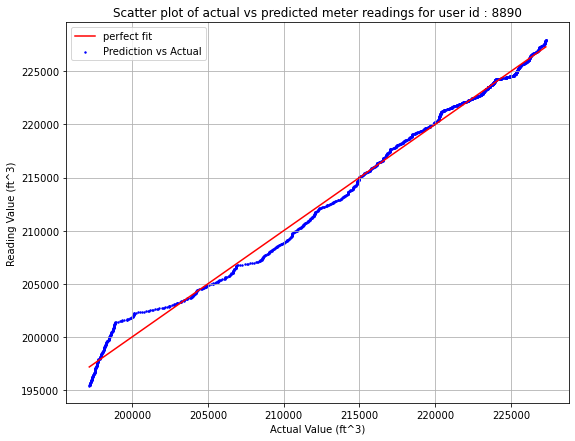

----------------------------------------------------------------




In [17]:
chosen_id=[35,44,739,8890] # chose several Gas meter for linear fitting
for i in chosen_id:
    poly_pred(user_id=i,hourly_OGdata=hourly_OGdata)
    plt.show()
    print('----------------------------------------------------------------\n\n')

As shown above， We used $MSE$ and $R^2$ score to estimate the accuracy of our prediction.<br> 

Gas meter|$MSE$|R^2 score
 :--------:  | :--------: | :--------:
35|	20137.477|	0.9981 
44|	98416.874|	0.97
739|	90652.276|	0.9939
8890|	458835.222|	0.9950

After evaluation, the fitting model enabled by Polynomial Regression Model is **no better** than the SVR model.
<br>Although **Polynomial Regression Model** shows better $MSE$ and $R^2$ results in some individual cases (eg. **Gas meter 44**), in general, SVR model performs better than Polynomial Regression Model.<br>

**Moreover**, the variation trend of the hourly reading approximates low-dimensional nonlinearity. Because SVR gets flexibility to define the level of error that can be acceptable in the model and to enable an appropriate line to fit the data，the **SVR model** performs better than linear regression model and poly-linear regression model.